In [1]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
!pip install geopandas
import geopandas

In [3]:
geo_df = geopandas.read_file('https://data.humdata.org/dataset/e66dbc70-17fe-4230-b9d6-855d192fc05c/resource/83dba4b0-992f-4748-b037-4b55ecc0c3b4/download/nigeria_lga.json')

In [4]:
x = [i for i in range(len(geo_df))
 if geo_df.loc[i,'NAME_1']=='Lagos']
lagos = geo_df.loc[x,:]

In [5]:
lagos.to_file("lagos_lga.geojson", driver='GeoJSON')

In [6]:
lagos[['ID_2','NAME_2']]

,ID_2,NAME_2
506,507,Agege
507,508,Ajeromi/Ifelodun
508,509,Alimosho
509,510,Amuwo Odofin
510,511,Apapa
511,512,Badagary
512,513,Epe
513,514,Eti-Osa
514,515,Ibeju/Lekki
515,516,Ifako/Ijaye


In [7]:
lagos_df = lagos[['ID_2','NAME_2']]
lagos_df= lagos_df.replace('Badagary','Badagry')
lagos_df= lagos_df.replace('LagosIsland','Lagos Island')
lagos_df

,ID_2,NAME_2
506,507,Agege
507,508,Ajeromi/Ifelodun
508,509,Alimosho
509,510,Amuwo Odofin
510,511,Apapa
511,512,Badagry
512,513,Epe
513,514,Eti-Osa
514,515,Ibeju/Lekki
515,516,Ifako/Ijaye


In [8]:
coordinates = {'LGA':[],'latitude':[],'longitude':[]}
for i in lagos_df['NAME_2']:
    address = f'{i}, Lagos'
    geolocator = Nominatim(user_agent="lag_explorer")
    location = geolocator.geocode(address)
    try:
        coordinates['latitude'].append(location.latitude)
        coordinates['longitude'].append(location.longitude)
        coordinates['LGA'].append(i)
    except AttributeError:
        print(f'{i} is a problem')

In [9]:
lagos_df = pd.DataFrame(coordinates)
lagos_df.set_index('LGA',inplace=True)
lagos_df

,latitude,longitude
LGA,,
Agege,6.625256,3.311209
Ajeromi/Ifelodun,6.455122,3.335946
Alimosho,6.584343,3.257631
Amuwo Odofin,6.447023,3.266280
Apapa,6.445187,3.368373
Badagry,6.438730,2.907486
Epe,6.524750,4.057246
Eti-Osa,6.460231,3.532181
Ibeju/Lekki,6.471125,3.814750


In [10]:
address = 'Lagos'

geolocator = Nominatim(user_agent="lag_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of {} are {}, {}.'.format(address,latitude, longitude))

The geograpical coordinates of Lagos are 6.4550575, 3.3941795.


In [11]:
map_lagos = folium.Map(location=[latitude, longitude], zoom_start=11)
map_lagos

In [13]:
# function that extracts the category of the venue
def get_category_type(row):
    '''
    This extracts the category of a location obtained from foursquare
    '''
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
lagos_df.loc['Agege',:].latitude

6.6252564

In [15]:
def get_foursquare(LGA,query):
    latitude= lagos_df.loc[LGA,:].latitude
    longitude = lagos_df.loc[LGA,:].longitude 
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&query={}&v={}'.format(
        CLIENT_ID, CLIENT_SECRET, latitude, longitude, query, VERSION
    )

    results = requests.get(url).json()

    nearby_venues = json_normalize(results['response']['venues']) # flatten JSON

    # filter columns
    nearby_venues =nearby_venues.loc[:, ['name', 'categories', 'location.lat', 'location.lng']]

    # filter the category for each row
    nearby_venues['categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    nearby_venues['LGA'] = [LGA]*len(nearby_venues)
    return nearby_venues

In [16]:
queries= ['organisation','business','office','bank','industry','corporation','plc','ltd','company','tech','school']

In [17]:
df = pd.DataFrame(columns=['name', 'categories', 'lat', 'lng', 'LGA'])
df

,name,categories,lat,lng,LGA


In [18]:
for LGA in lagos_df.index:
    print(LGA)
    for query in queries:
        try:
            df = df.append(get_foursquare(LGA,query), ignore_index=True)
        except:
            continue

Agege
Ajeromi/Ifelodun
Alimosho
Amuwo Odofin
Apapa
Badagry
Epe
Eti-Osa
Ibeju/Lekki
Ifako/Ijaye
Ikeja
Ikorodu
Kosofe
Lagos Island
Mainland
Mushin
Ojo
Oshodi/Isolo
Shomolu
Surulere


In [19]:
df.head()

,name,categories,lat,lng,LGA
0,Standards Organisation of Nigeria,Government Building,6.438771,3.456322,Agege
1,SoluTech Business Solutions,None,6.633049,3.306640,Agege
2,Business Class Lounge,Travel Lounge,6.584789,3.332613,Agege
3,Business With Measure Digital Marketing Agency,Advertising Agency,6.586949,3.356983,Agege
4,"NECA House Plot A2, Hakeem Balogun Street, Cen...",Conference Room,6.623344,3.358132,Agege


In [20]:
df.shape

(4604, 5)

In [21]:
df['categories'].unique()

array(['Government Building', None, 'Travel Lounge', 'Advertising Agency',
       'Conference Room', 'Office', 'Coworking Space', 'Business Center',
       'Airport', 'School', 'Lounge', 'Plaza',
       'Professional & Other Places', 'College Administrative Building',
       'Building', 'Business Service', 'Hotel', 'Post Office',
       'Paper / Office Supplies Store', 'Embassy / Consulate',
       'Capitol Building', 'Tourist Information Center', 'Tech Startup',
       'Bank', 'Community Center', 'Factory', 'Food Truck',
       'Harbor / Marina', 'Convention Center', 'Non-Profit',
       'Warehouse Store', 'Farmers Market', 'General Entertainment',
       'Medical Center', 'Mobile Phone Shop', 'Electronics Store',
       'Hospital', "Men's Store", 'Pharmacy', 'Automotive Shop',
       'Health & Beauty Service', 'Dance Studio', 'Bus Line',
       'Power Plant', 'Film Studio', 'IT Services', 'Corporate Amenity',
       'Art Gallery', 'College Cafeteria', 'Nursery School',
       'Elemen

In [22]:
noise = [None, 'Food Truck','Warehouse Store', 'Farmers Market','Bus Line','College Cafeteria','Miscellaneous Shop','College Classroom',
'Voting Booth','College Auditorium','Bus Station','College Lab','BBQ Joint','Taxi','Storage Facility','Meeting Room',  'Bed & Breakfast']

In [23]:
x = [i for i in range(len(df))
 if df.loc[i,'categories'] not in noise]
clean_df = df.loc[x,:]

In [24]:
clean_df.shape

(3787, 5)

In [25]:
clean_df['categories'].unique()

array(['Government Building', 'Travel Lounge', 'Advertising Agency',
       'Conference Room', 'Office', 'Coworking Space', 'Business Center',
       'Airport', 'School', 'Lounge', 'Plaza',
       'Professional & Other Places', 'College Administrative Building',
       'Building', 'Business Service', 'Hotel', 'Post Office',
       'Paper / Office Supplies Store', 'Embassy / Consulate',
       'Capitol Building', 'Tourist Information Center', 'Tech Startup',
       'Bank', 'Community Center', 'Factory', 'Harbor / Marina',
       'Convention Center', 'Non-Profit', 'General Entertainment',
       'Medical Center', 'Mobile Phone Shop', 'Electronics Store',
       'Hospital', "Men's Store", 'Pharmacy', 'Automotive Shop',
       'Health & Beauty Service', 'Dance Studio', 'Power Plant',
       'Film Studio', 'IT Services', 'Corporate Amenity', 'Art Gallery',
       'Nursery School', 'Elementary School', 'High School',
       'General College & University', 'Spa', 'College Academic Building',


In [26]:
sub = clean_df.groupby('LGA').apply(lambda x: len(x))
sub = pd.DataFrame(sub.items(),columns = ['LGA','Count'])

In [27]:
sub.sort_values(by = 'Count').tail()

,LGA,Count
11,Ikorodu,224
0,Agege,225
15,Mushin,226
10,Ikeja,228
7,Eti-Osa,232


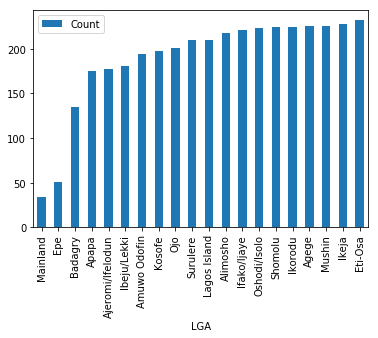

In [30]:
sub.sort_values(by='Count').plot(kind='bar', x='LGA',y='Count')

### The top 5 recommended Neighborhoods will thus be:
-  **Eti-Osa**
-  **Ikeja**
-  **Mushin**
-  **Agege**
-  **Ikorodu**


In [45]:
address = 'Lagos'

geolocator = Nominatim(user_agent="lag_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of {} are {}, {}.'.format(address,latitude, longitude))

The geograpical coordinates of Lagos are 6.4550575, 3.3941795.


In [47]:
# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
lagos = r'lagos_lga.geojson'
lagos_map = folium.Map(location=[latitude, longitude], zoom_start=10)
folium.Choropleth(
    geo_data=lagos,
    data= sub,
    columns=['LGA', 'Count'],
    key_on='feature.properties.NAME_2',
    fill_color='PuBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of Offices in Local Government Area'
).add_to(lagos_map)

lagos_map.save('index.html')
# display map
lagos_map


In [48]:
clean_df.head()

,name,categories,lat,lng,LGA
0,Standards Organisation of Nigeria,Government Building,6.438771,3.456322,Agege
2,Business Class Lounge,Travel Lounge,6.584789,3.332613,Agege
3,Business With Measure Digital Marketing Agency,Advertising Agency,6.586949,3.356983,Agege
4,"NECA House Plot A2, Hakeem Balogun Street, Cen...",Conference Room,6.623344,3.358132,Agege
5,Jodphur Business Ventures / A2global shipping,Office,6.595537,3.347213,Agege


In [33]:
# one hot encoding
lagos_onehot = pd.get_dummies(clean_df,columns=['categories'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
lagos_onehot['LGA'] = clean_df['LGA'] 

# move neighborhood column to the first column
fixed_columns = [lagos_onehot.columns[-1]] + list(lagos_onehot.columns[:-1])
lagos_onehot = lagos_onehot[fixed_columns]

lagos_onehot.head()

,Winery,name,lat,lng,LGA,Advertising Agency,Airport,Airport Terminal,Arcade,Art Gallery,Athletics & Sports,Auto Dealership,Automotive Shop,Bank,Bar,Baseball Stadium,Beer Garden,Boarding House,Boat or Ferry,Bookstore,Building,Business Center,Business Service,Capitol Building,Carpet Store,Clothing Store,College & University,College Academic Building,College Administrative Building,College Arts Building,College Communications Building,College Engineering Building,College History Building,College Library,College Quad,College Residence Hall,College Technology Building,Comedy Club,Comic Shop,Community Center,Community College,Conference Room,Construction & Landscaping,Convention Center,Corporate Amenity,Coworking Space,Dance Studio,Dentist's Office,Department Store,Design Studio,Distribution Center,Electronics Store,Elementary School,Embassy / Consulate,Eye Doctor,Factory,Film Studio,Food Court,Furniture / Home Store,Gas Station,General College & University,General Entertainment,General Travel,Gift Shop,Government Building,Grocery Store,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Home Service,Hospital,Hotel,IT Services,Internet Cafe,Laundry Service,Law School,Library,Liquor Store,Lottery Retailer,Lounge,Market,Medical Center,Medical Lab,Medical School,Men's Store,Middle School,Military Base,Mobile Phone Shop,Motel,Music Venue,Non-Profit,Nursery School,Office,Other Great Outdoors,Other Repair Shop,Paper / Office Supplies Store,Pharmacy,Photography Lab,Playground,Plaza,Police Station,Pool,Post Office,Power Plant,Private School,Professional & Other Places,Real Estate Office,Recycling Facility,Rental Car Location,Residential Building (Apartment / Condo),Salon / Barbershop,School,Shipping Store,Spa,Student Center,Tech Startup,Tourist Information Center,Toy / Game Store,Trade School,Train Station,Travel Agency,Travel Lounge,University,Video Game Store,Warehouse
0,0,Standards Organisation of Nigeria,6.438771,3.456322,Agege,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,Business Class Lounge,6.584789,3.332613,Agege,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,Business With Measure Digital Marketing Agency,6.586949,3.356983,Agege,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,"NECA House Plot A2, Hakeem Balogun Street, Cen...",6.623344,3.358132,Agege,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,Jodphur Business Ventures / A2global shipping,6.595537,3.347213,Agege,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
lagos_onehot.shape

(3787, 126)

In [35]:
lagos_grouped = lagos_onehot.groupby('LGA').mean().reset_index()
lagos_grouped

,LGA,Winery,lat,lng,Advertising Agency,Airport,Airport Terminal,Arcade,Art Gallery,Athletics & Sports,Auto Dealership,Automotive Shop,Bank,Bar,Baseball Stadium,Beer Garden,Boarding House,Boat or Ferry,Bookstore,Building,Business Center,Business Service,Capitol Building,Carpet Store,Clothing Store,College & University,College Academic Building,College Administrative Building,College Arts Building,College Communications Building,College Engineering Building,College History Building,College Library,College Quad,College Residence Hall,College Technology Building,Comedy Club,Comic Shop,Community Center,Community College,Conference Room,Construction & Landscaping,Convention Center,Corporate Amenity,Coworking Space,Dance Studio,Dentist's Office,Department Store,Design Studio,Distribution Center,Electronics Store,Elementary School,Embassy / Consulate,Eye Doctor,Factory,Film Studio,Food Court,Furniture / Home Store,Gas Station,General College & University,General Entertainment,General Travel,Gift Shop,Government Building,Grocery Store,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Home Service,Hospital,Hotel,IT Services,Internet Cafe,Laundry Service,Law School,Library,Liquor Store,Lottery Retailer,Lounge,Market,Medical Center,Medical Lab,Medical School,Men's Store,Middle School,Military Base,Mobile Phone Shop,Motel,Music Venue,Non-Profit,Nursery School,Office,Other Great Outdoors,Other Repair Shop,Paper / Office Supplies Store,Pharmacy,Photography Lab,Playground,Plaza,Police Station,Pool,Post Office,Power Plant,Private School,Professional & Other Places,Real Estate Office,Recycling Facility,Rental Car Location,Residential Building (Apartment / Condo),Salon / Barbershop,School,Shipping Store,Spa,Student Center,Tech Startup,Tourist Information Center,Toy / Game Store,Trade School,Train Station,Travel Agency,Travel Lounge,University,Video Game Store,Warehouse
0,Agege,0.000000,6.583856,3.343809,0.004444,0.008889,0.000000,0.000000,0.004444,0.000000,0.000000,0.004444,0.191111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044444,0.004444,0.026667,0.004444,0.000000,0.000000,0.000000,0.008889,0.004444,0.000000,0.000000,0.000000,0.004444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004444,0.008889,0.013333,0.000000,0.004444,0.008889,0.026667,0.008889,0.000000,0.000000,0.000000,0.000000,0.008889,0.017778,0.004444,0.000000,0.066667,0.004444,0.00000,0.000000,0.000000,0.004444,0.013333,0.000000,0.000000,0.044444,0.000000,0.004444,0.000000,0.004444,0.017778,0.000000,0.004444,0.004444,0.013333,0.000000,0.00000,0.000000,0.004444,0.000000,0.000000,0.008889,0.000000,0.004444,0.000000,0.004444,0.004444,0.000000,0.000000,0.004444,0.000000,0.000000,0.004444,0.008889,0.191111,0.000000,0.00000,0.013333,0.004444,0.000000,0.000000,0.004444,0.000000,0.000000,0.008889,0.004444,0.004444,0.017778,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.004444,0.000000,0.048889,0.008889,0.000000,0.000000,0.000000,0.000000,0.004444,0.000000,0.000000,0.000000
1,Ajeromi/Ifelodun,0.000000,6.474705,3.363968,0.005650,0.005650,0.000000,0.000000,0.011299,0.000000,0.000000,0.000000,0.220339,0.000000,0.005650,0.000000,0.000000,0.000000,0.005650,0.050847,0.005650,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000,0.005650,0.000000,0.005650,0.005650,0.000000,0.000000,0.005650,0.000000,0.005650,0.000000,0.005650,0.000000,0.000000,0.011299,0.000000,0.005650,0.000000,0.028249,0.005650,0.000000,0.000000,0.000000,0.000000,0.011299,0.005650,0.000000,0.000000,0.050847,0.005650,0.00000,0.005650,0.000000,0.000000,0.000000,0.000000,0.000000,0.045198,0.000000,0.011299,0.005650,0.000000,0.016949,0.000000,0.000000,0.005650,0.011299,0.005650,0.00000,0.000000,0.000000,0.005650,0.000000,0.011299,0.005650,0.000000,0.000000,0.005650,0.000000,0.005650,0.005650,0.005650,0.000000,0.000000,0.005650,0.000000,0.203390,0.000000,0.00565,0.016949,0.000000,0.000000,0.005650,0.005650,0.005650,0.000000,0.005650,0.000000,0.000000,0.011299,0.000000,0.000000,

In [36]:
from sklearn import metrics 
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [38]:
distortions = [] 
mapping1 = {} 
K = range(1,15) 

for k in K: 
    #Building and fitting the model
    lagos_grouped1 = lagos_grouped.drop(['lat','lng','LGA'],axis=1)
    kmeanModel = KMeans(n_clusters=k).fit(lagos_grouped1) 
    kmeanModel.fit(lagos_grouped1)
    
    distortions.append(sum(np.min(cdist(lagos_grouped1, kmeanModel.cluster_centers_, 
        'euclidean'),axis=1)) / lagos_grouped1.shape[0]) 

    mapping1[k] = sum(np.min(cdist(lagos_grouped1, kmeanModel.cluster_centers_, 
            'euclidean'),axis=1)) / lagos_grouped1.shape[0] 

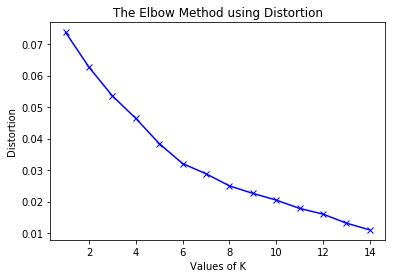

In [39]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

In [40]:
# set number of clusters
kclusters = 6

lagos_grouped_clustering = lagos_grouped.drop(['lat','lng','LGA'],axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(lagos_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 0, 2, 4, 5, 2, 2, 1], dtype=int32)

In [41]:
lagos_grouped['Cluster Labels']= kmeans.labels_

In [42]:
lagos_grouped.head()

,LGA,Winery,lat,lng,Advertising Agency,Airport,Airport Terminal,Arcade,Art Gallery,Athletics & Sports,Auto Dealership,Automotive Shop,Bank,Bar,Baseball Stadium,Beer Garden,Boarding House,Boat or Ferry,Bookstore,Building,Business Center,Business Service,Capitol Building,Carpet Store,Clothing Store,College & University,College Academic Building,College Administrative Building,College Arts Building,College Communications Building,College Engineering Building,College History Building,College Library,College Quad,College Residence Hall,College Technology Building,Comedy Club,Comic Shop,Community Center,Community College,Conference Room,Construction & Landscaping,Convention Center,Corporate Amenity,Coworking Space,Dance Studio,Dentist's Office,Department Store,Design Studio,Distribution Center,Electronics Store,Elementary School,Embassy / Consulate,Eye Doctor,Factory,Film Studio,Food Court,Furniture / Home Store,Gas Station,General College & University,General Entertainment,General Travel,Gift Shop,Government Building,Grocery Store,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Home Service,Hospital,Hotel,IT Services,Internet Cafe,Laundry Service,Law School,Library,Liquor Store,Lottery Retailer,Lounge,Market,Medical Center,Medical Lab,Medical School,Men's Store,Middle School,Military Base,Mobile Phone Shop,Motel,Music Venue,Non-Profit,Nursery School,Office,Other Great Outdoors,Other Repair Shop,Paper / Office Supplies Store,Pharmacy,Photography Lab,Playground,Plaza,Police Station,Pool,Post Office,Power Plant,Private School,Professional & Other Places,Real Estate Office,Recycling Facility,Rental Car Location,Residential Building (Apartment / Condo),Salon / Barbershop,School,Shipping Store,Spa,Student Center,Tech Startup,Tourist Information Center,Toy / Game Store,Trade School,Train Station,Travel Agency,Travel Lounge,University,Video Game Store,Warehouse,Cluster Labels
0,Agege,0.0,6.583856,3.343809,0.004444,0.008889,0.000000,0.0,0.004444,0.0,0.0,0.004444,0.191111,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.044444,0.004444,0.026667,0.004444,0.0,0.0,0.0,0.008889,0.004444,0.000000,0.000000,0.000000,0.004444,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.004444,0.008889,0.013333,0.0,0.004444,0.008889,0.026667,0.008889,0.0,0.0,0.0,0.0,0.008889,0.017778,0.004444,0.000000,0.066667,0.004444,0.0,0.000000,0.000000,0.004444,0.013333,0.000000,0.0,0.044444,0.000000,0.004444,0.000000,0.004444,0.017778,0.0,0.004444,0.004444,0.013333,0.000000,0.0,0.0,0.004444,0.000000,0.0,0.008889,0.000000,0.004444,0.0,0.004444,0.004444,0.000000,0.000000,0.004444,0.000000,0.0,0.004444,0.008889,0.191111,0.0,0.00000,0.013333,0.004444,0.0,0.000000,0.004444,0.000000,0.0,0.008889,0.004444,0.004444,0.017778,0.0,0.0,0.0,0.0,0.000000,0.040000,0.000000,0.004444,0.0,0.048889,0.008889,0.0,0.000000,0.0,0.0,0.004444,0.000000,0.0,0.000000,1
1,Ajeromi/Ifelodun,0.0,6.474705,3.363968,0.005650,0.005650,0.000000,0.0,0.011299,0.0,0.0,0.000000,0.220339,0.000000,0.005650,0.000000,0.0,0.0,0.005650,0.050847,0.005650,0.016949,0.000000,0.0,0.0,0.0,0.000000,0.005650,0.000000,0.005650,0.005650,0.000000,0.0,0.005650,0.0,0.005650,0.0,0.005650,0.000000,0.000000,0.011299,0.0,0.005650,0.000000,0.028249,0.005650,0.0,0.0,0.0,0.0,0.011299,0.005650,0.000000,0.000000,0.050847,0.005650,0.0,0.005650,0.000000,0.000000,0.000000,0.000000,0.0,0.045198,0.000000,0.011299,0.005650,0.000000,0.016949,0.0,0.000000,0.005650,0.011299,0.005650,0.0,0.0,0.000000,0.005650,0.0,0.011299,0.005650,0.000000,0.0,0.005650,0.000000,0.005650,0.005650,0.005650,0.000000,0.0,0.005650,0.000000,0.203390,0.0,0.00565,0.016949,0.000000,0.0,0.005650,0.005650,0.005650,0.0,0.005650,0.000000,0.000000,0.011299,0.0,0.0,0.0,0.0,0.005650,0.056497,0.000000,0.000000,0.0,0.022599,0.000000,0.0,0.005650,0.0,0.0,0.005650,0.000000,0.0,0.000000,1
2,Alimosho,0.0,6.564142,3.330558,0.009174,0.013761,0.004587,0.0,0.004587,0.0,0.0,0.004587,0.197248,0.000000,0.000000,0.004587,0.0,0.0,0.004587,0.036697,0.004587,0.018349,0.004587,0.0,0.0,0.0,0.0

In [51]:
map_clusters = folium.Map(location = [latitude, longitude],zoom_start=10)

In [52]:
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(lagos_df['latitude'], lagos_df['longitude'], lagos_grouped['LGA'], lagos_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [53]:
sub['Cluster Labels']= kmeans.labels_

In [54]:
clusters = sub.groupby('Cluster Labels')
clusters['Count'].sum()

Cluster Labels
0    1476
1    1293
2     798
3      34
4     135
5      51
Name: Count, dtype: int64

In [55]:
print('The Local Government Areas in cluster 0 are:')
tuple(clusters)[0][1]['LGA']

The Local Government Areas in cluster 0 are:


3     Amuwo Odofin
12          Kosofe
15          Mushin
16             Ojo
17    Oshodi/Isolo
18         Shomolu
19        Surulere
Name: LGA, dtype: object

In [56]:
print('The Local Government Areas in cluster 1 are:')

tuple(clusters)[1][1]['LGA']

The Local Government Areas in cluster 1 are:


0                Agege
1     Ajeromi/Ifelodun
2             Alimosho
9          Ifako/Ijaye
10               Ikeja
11             Ikorodu
Name: LGA, dtype: object